<h1 style="background-color:#afe6ad; color:Black; text-align:center;">Projeto PLN</h1>

<div style="text-align:center;">
    Projeto de Processamento de Linguagem Natural - Correlação de artigos sobre saúde mental<br>
    Michel Ribeiro Koba - 792211
</div>

### **Dependências**

<h4 style="color:#7977a8">Bibliotecas</h4>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import re
import spacy

import nltk
from langdetect import detect
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('portuguese'))
nlp = spacy.load("pt_core_news_lg")


from gensim.models import Word2Vec
from gensim.models import FastText

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

<h4 style="color:#7977a8">DataSet</h4>

In [186]:
df = pd.read_csv('export2.csv')
df = df[df['Language'] == 'pt']
df = df[["Title", "Keyword(s)", " Abstract"]]
df = df.rename(columns={"Title": "Titulo", "Keyword(s)": "PalavrasChave", " Abstract": "Resumo"})
display(df.columns)
display(df.shape)

Index(['Titulo', 'PalavrasChave', 'Resumo'], dtype='object')

(323, 3)

### **Implementação**

#### Pré Processamento

In [187]:
# Função para normalização do texto
def preprocessing(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r'<[^<>]+>', ' ', text)
    text = re.sub(r'\d+', 'NÚMERO', text)
    text = re.sub(r'(http|https)://[^\s]+', 'WEBSITE', text)
    text = re.sub(r'[^\s]+@[^\s]+', 'EMAIL', text)
    text = re.sub(r'\$', 'dolar', text)
    text = re.sub(r'[^a-zA-Zà-úÀ-Ú]', ' ', text)
    text = ' '.join(text.split())
    return text

# Função para lematização e remoção das stopwords
def tokenize_lemmatize(text):
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != ''
    ]
    return tokens

# Função auxiliar para detecção de palavras/textos em português
def is_portuguese(text):
    try:
        return detect(text) == 'pt'
    except:
        return False

In [188]:
df['ResumoPre'] = df['Resumo'].apply(preprocessing)
df['Tokens'] = df['ResumoPre'].apply(tokenize_lemmatize)

corpus_resumo = df['Tokens'].tolist()

In [ ]:
df['PalavrasChavePre'] = df['PalavrasChave'].apply(preprocessing)
df['TokensPC'] = df['PalavrasChavePre'].apply(tokenize_lemmatize)

corpus_pc = df['TokensPC'].tolist()

In [189]:
df['TituloPre'] = df['Titulo'].apply(preprocessing)
df['TokensTitulo'] = df['TituloPre'].apply(tokenize_lemmatize)

corpus_titulo = df['TokensTitulo'].tolist()

#### Treinamento dos modelos

In [204]:
model = Word2Vec(
    sentences=corpus_resumo,
    vector_size=10,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)
# sintoma, prevenção, criança, saúde, política
# print(model.wv.most_similar('saúde', topn=30))

In [205]:
model_fast = FastText(
    sentences=corpus_resumo,
    vector_size=10,
    window=5,
    min_count=3,
    workers=4,
    sg=1
)


#### Avaliação Qualitativa

In [194]:
def cosine_similarity_wordpair(model, w1, w2):
    if w1 in model.wv and w2 in model.wv:
        vec1 = model.wv[w1].reshape(1, -1)
        vec2 = model.wv[w2].reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    return None


In [203]:
# Alterar pares para outras comparações entre modelos
pares = [
    ("sintoma", "ansiedade"),
    ("sintoma", "estresse"),
    ("sintoma", "depressão"),
    ("sintoma", "tristeza"),
    ("sintoma", "sono"),
    ("feliz", "depressão"),
    ("política", "prevenção"),
    ("ansiedade", "biblioteca")
]

print(f"{'Par':<35} | Word2Vec | FastText")
print("-" * 55)

for w1, w2 in pares:
    sim_w2v = cosine_similarity_wordpair(model, w1, w2)
    sim_fast = cosine_similarity_wordpair(model_fast, w1, w2)

    sim_w2v_str = f"{sim_w2v:.4f}" if sim_w2v is not None else "N/A"
    sim_fast_str = f"{sim_fast:.4f}" if sim_fast is not None else "N/A"

    print(f"{w1:>12} ↔ {w2:<20} | {sim_w2v_str:>8} | {sim_fast_str:>8}")


Par                                 | Word2Vec | FastText
-------------------------------------------------------
     sintoma ↔ ansiedade            |   0.8795 |   0.9998
     sintoma ↔ estresse             |   0.8711 |   0.9998
     sintoma ↔ depressão            |   0.8889 |   0.9998
     sintoma ↔ tristeza             |      N/A |   0.9986
     sintoma ↔ sono                 |   0.8722 |   0.9979
       feliz ↔ depressão            |      N/A |   0.9804
    política ↔ prevenção            |   0.1595 |   0.9997
   ansiedade ↔ biblioteca           |      N/A |   0.9963


#### Avaliação Quantitativa

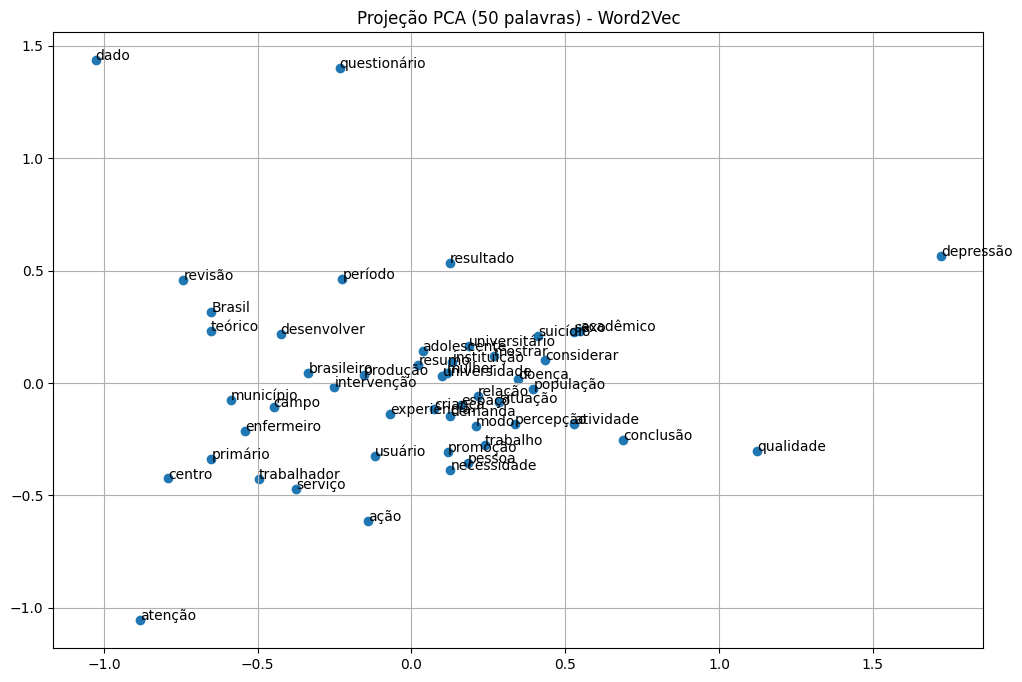

In [ ]:
top_words = list(model.wv.key_to_index.keys())[:1000]
vocab = [word for word in top_words if is_portuguese(word)]
vocab = vocab[:50]

vectors = [model.wv[word] for word in vocab]

# PCA
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(vocab):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.title("Projeção PCA (50 palavras) - Word2Vec")
plt.grid(True)
plt.show()


d:\Faculdade\Mestrado\implementations\nlp-env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Faculdade\Mestrado\implementations\nlp-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


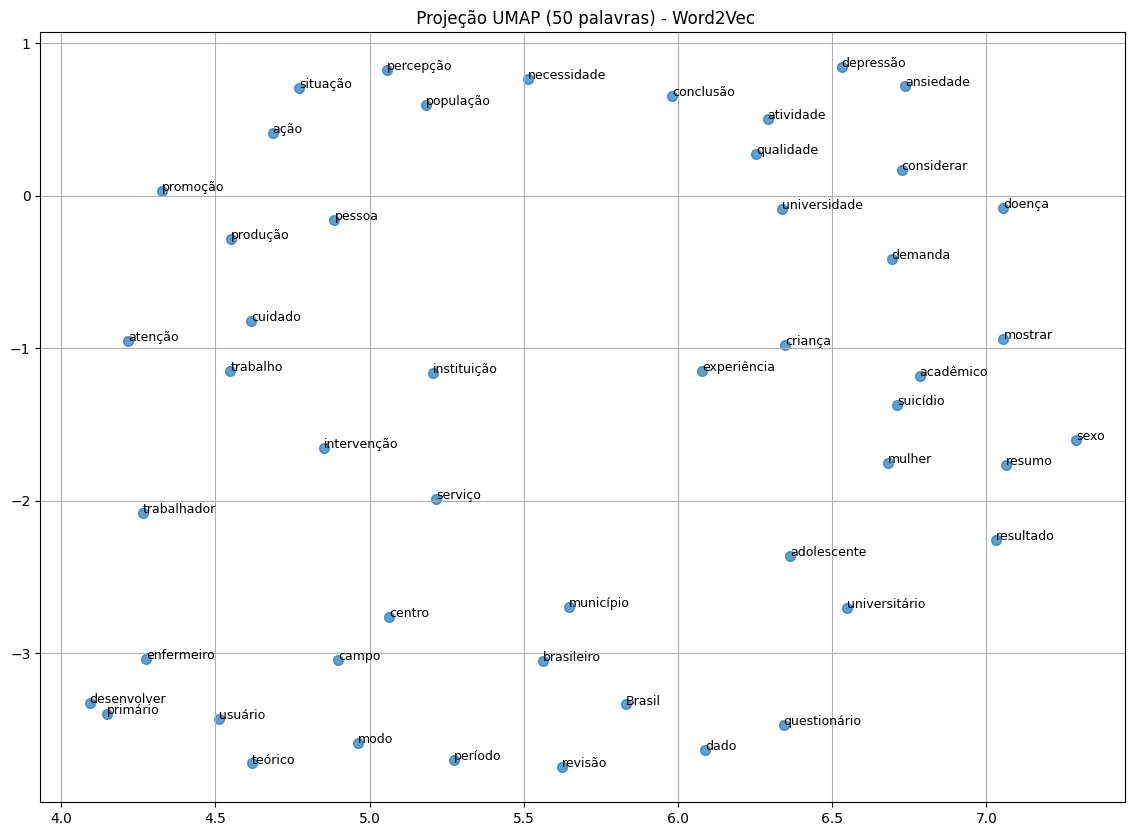

In [ ]:
top_words = list(model_fast.wv.key_to_index.keys())[:3000]
vocab = [word for word in top_words if is_portuguese(word)]
vocab = vocab[:1000]

vocab = []
vectors = []

for word in top_words:
    if is_portuguese(word):
        vocab.append(word)
        vectors.append(model_fast.wv[word])
        if len(vocab) >= 50:
            break

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding = reducer.fit_transform(vectors)

# Plot
plt.figure(figsize=(14, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], s=50, alpha=0.7)

for i, word in enumerate(vocab):
    plt.annotate(word, (embedding[i, 0], embedding[i, 1]), fontsize=9)

plt.title(" Projeção UMAP (50 palavras) - Word2Vec")
plt.grid(True)
plt.show()


A clusterização das palavras não gerou um valor analítico muito bom para o modelo treinado :(

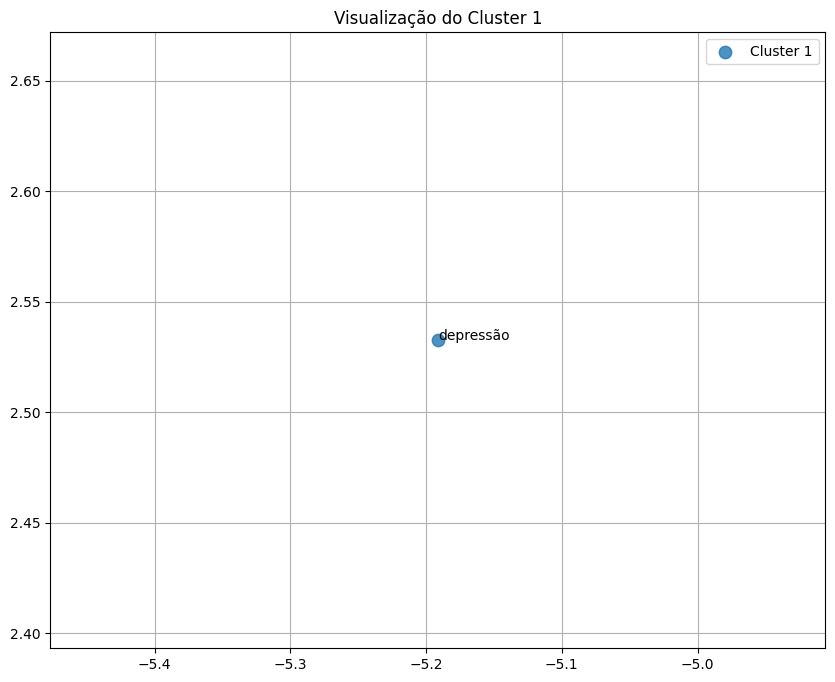

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(vectors)

# Aqui vc pode selecionar um id específico para visualizar
cluster_id = 0


idx = [j for j, label in enumerate(labels) if label == cluster_id]

plt.figure(figsize=(10, 8))
plt.scatter(
    [embedding[j, 0] for j in idx],
    [embedding[j, 1] for j in idx],
    label=f'Cluster {cluster_id + 1}',
    s=80,
    alpha=0.8,
    color='tab:blue'
)

for j in idx:
    plt.annotate(vocab[j], (embedding[j, 0], embedding[j, 1]), fontsize=10)

plt.title(f"Visualização do Cluster {cluster_id + 1}")
plt.legend()
plt.grid(True)
plt.show()


d:\Faculdade\Mestrado\implementations\nlp-env\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Faculdade\Mestrado\implementations\nlp-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
d:\Faculdade\Mestrado\implementations\nlp-env\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


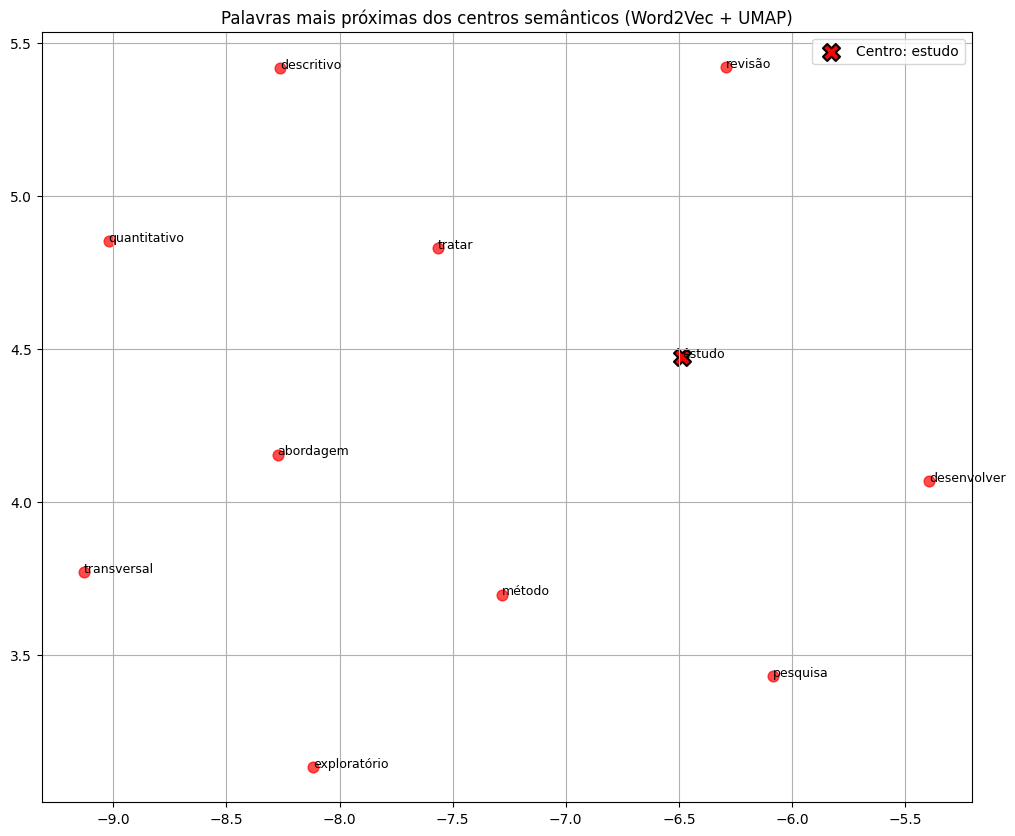

In [ ]:
# centros = ["sintoma", "estudo", "suicídio", "tratamento"]
# Aqui vc pode passar qual centro utilizar ou passar como uma lista de centros para vizualação múltipla
# Exemplo centros = ["estudo", "sintoma"]
centros = ["estudo"]

todas_palavras = []
todas_cores = []
cores = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']

for i, centro in enumerate(centros):
    if centro in model.wv:
        similares = model.wv.most_similar(centro, topn=10)
        palavras = [centro] + [w for w, _ in similares]
        todas_palavras.extend(palavras)
        todas_cores.extend([cores[i % len(cores)]] * len(palavras))

vetores = [model.wv[w] for w in todas_palavras]

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.4, metric='cosine', random_state=42)
embedding = reducer.fit_transform(vetores)

# Plot
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(embedding):
    word = todas_palavras[i]
    cor = todas_cores[i]
    is_centro = word in centros

    if is_centro:
        plt.scatter(x, y, s=150, c=cor, marker='X', edgecolor='black', linewidths=1.5, label=f'Centro: {word}')
    else:
        plt.scatter(x, y, s=60, c=cor, alpha=0.7)

    plt.annotate(word, (x, y), fontsize=9)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Palavras mais próximas dos centros semânticos (Word2Vec + UMAP)")
plt.grid(True)
plt.show()
